<a href="https://colab.research.google.com/github/peasantxuan/prediction_fondation_model/blob/main/Heat_map_figure_matric_box_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load required libraries
library(ggplot2)
library(dplyr)
library(scales)
all_pic_data <- read.csv("all_pic_data.csv", stringsAsFactors = TRUE)

# Convert date columns to Date format
all_pic_data$date_pic <- as.Date(all_pic_data$date_pic)
all_pic_data$data_pic_date <- as.Date(all_pic_data$data_pic_date)

all_pic_data$Model <- as.factor(all_pic_data$Model)
all_pic_data$Data <- as.factor(all_pic_data$Data)
all_pic_data$training_time <- as.factor(all_pic_data$training_time)
all_pic_data$training_time <- as.factor(all_pic_data$training_time)
all_pic_data$Scenario <- as.factor(all_pic_data$Scenario)


valid_diseases <- c("RSV", "ILI", "Flu", "Dengue", "Chickenpox")
all_pic_data <- all_pic_data[all_pic_data$Data %in% valid_diseases, ]
all_pic_data$Data <- factor(all_pic_data$Data)

all_pic_data$distance_to_peak = all_pic_data$data_pic_date-all_pic_data$date_pic
all_pic_data$distance_to_peak_weeks <- all_pic_data$distance_to_peak / 7
all_pic_data$distance_to_peak_abs = abs(all_pic_data$distance_to_peak)

In [ ]:
unique(all_pic_data$Model)

[1] SARIMA              Prophet             mpf                
[4] compartmental_model TimeGPT             TimeSFM            
[7] tabPFN              Chronos             LagLlama64         
9 Levels: Chronos compartmental_model LagLlama64 mpf Prophet SARIMA ... TimeSFM

In [ ]:
library(forcats)


# Recode the Models levels
all_pic_data$Models <- fct_recode(all_pic_data$Model,  # Rename Model -> Models
  "TabPFN" = "tabPFN",
  "TimesGPT" = "TimeGPT",
  "TimesFM" = "TimeSFM",
  "Chronos" = "Chronos",
  "Lag-Llama" = "LagLlama64",
  "SARIMA" = "SARIMA",
  "Prophet" = "Prophet",
  "Mechanistic" = "compartmental_model",
  "Parieau" = "mpf"  # Assuming 'mpf' corresponds to 'Parieau'
)

# Define the desired order of factor levels
desired_levels <- c("Mechanistic", "Prophet", "SARIMA", "(LSTM)", "Lag-Llama",
                    "Chronos", "TimesFM", "TimesGPT", "TabPFN")

all_pic_data <- all_pic_data[all_pic_data$Models%in% c("Mechanistic", "Prophet", "SARIMA", "(LSTM)", "Lag-Llama",
                    "Chronos", "TimesFM", "TimesGPT", "TabPFN"), ]

# Ensure factor levels match the desired sequence
all_pic_data$Models <- factor(all_pic_data$Models, levels = desired_levels)

# Remove the old Model column if necessary
all_pic_data$Model <- NULL
all_pic_data$Model_Type <- ifelse(all_pic_data$Models %in% c("Mechanistic", "Prophet", "SARIMA"),
                                  "Benchmark Model", "Foundation Model")



# Rename the variable Data to Diseases
all_pic_data$Diseases <- all_pic_data$Data
desired_disease_levels <- c("ILI", "Flu", "RSV", "Chickenpox", "Dengue")
all_pic_data$Diseases <- factor(all_pic_data$Diseases, levels = desired_disease_levels)
all_pic_data$Data <- NULL


library(forcats)

# Rename the variable training_time to Forecast_horizons
all_pic_data$Forecast_horizons <- all_pic_data$training_time

# Recode training time values to match the desired names
all_pic_data$Forecast_horizons <- fct_recode(all_pic_data$Forecast_horizons,
  "EARLY" = "October",
  "Nov" = "November",
  "-4w" = "4 weeks before actual peak",
  "-2w" = "2 weeks before actual peak"
)
#all_pic_data <- all_pic_data[all_pic_data$Forecast_horizons %in% c("Oct", "Nov", "-4w", "-2w"), ]
#desired_forecast_levels <- c("Oct", "Nov", "-4w", "-2w")

all_pic_data <- all_pic_data[all_pic_data$Forecast_horizons %in% c("EARLY", "-4w"), ]
desired_forecast_levels <- c("EARLY", "-4w")

all_pic_data$Forecast_horizons <- factor(all_pic_data$Forecast_horizons, levels = desired_forecast_levels)
all_pic_data$training_time <- NULL




In [ ]:
install.packages("showtext")
library(showtext)
system("apt-get install -y fonts-dejavu-core")  # Install DejaVu Sans
font_add("DejaVu Sans", "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf")  # Add font manually
showtext_auto()

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



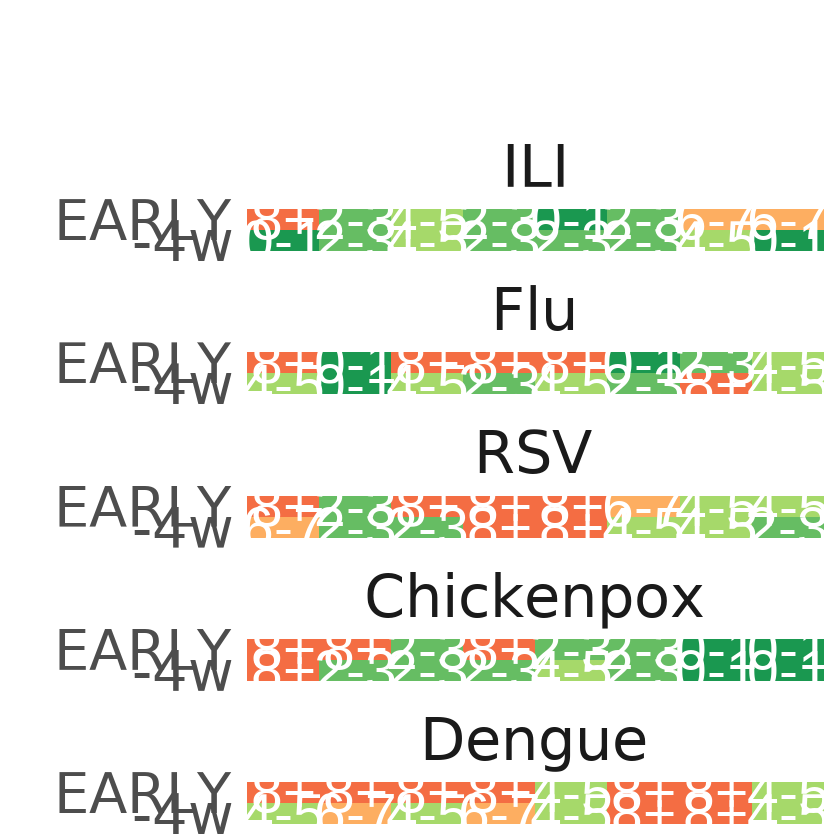

In [ ]:
heatmap_data_2018 <- all_pic_data %>%
  filter(Year == 2018) %>%
  group_by(Models, Diseases, Forecast_horizons) %>%  # Include training_time for facet x-axis
  ungroup()


heatmap_data_2018$distance_category <- cut(
  as.numeric(heatmap_data_2018$distance_to_peak_abs / 7),
  breaks = c(-Inf,1, 3, 5, 7, Inf),
  labels = c("0-1", "2-3", "4-5", "6-7", "8+"),
  right = TRUE
)


# Define color palette
color_palette <- c(
  "#1a9850",  # Dark Green (Lowest)
  "#66bd63",  # Light Green
  "#a6d96a",  # Yellow-Green
  "#fdae61",  # Orange
  "#f46d43",  # Red-Orange
  "#d73027"   # Dark Red (Highest)
)

ggplot(heatmap_data_2018, aes(x = Models,
                              y = factor(Forecast_horizons, levels = rev(unique(Forecast_horizons))),
                              fill = distance_category)) +
  geom_tile() +
  geom_text(aes(label = distance_category), color = "white", size = 15) +

  # Use 2 columns for facet arrangement
  facet_wrap(~ Diseases, ncol = 1, scales = "free_x") +

  # Change legend title
  scale_fill_manual(values = color_palette, name = "Absolute Distance to the Peak (week)") +
  labs(x = "Models", y = NULL) +  # Remove y-axis title
  ggtitle("") +
  theme_minimal() +
  theme(
    text = element_text(family = "DejaVu Sans"),
    axis.text.x = element_blank(),  # Remove x-axis text
    #axis.text.x = element_text(size = 42, angle = 90, vjust = 0.5, hjust = 1),
    axis.text.y = element_text(size = 42),
    axis.title.x = element_blank(),
    strip.text = element_text(size = 44, face = "plain"),
    panel.grid = element_blank(),
    panel.border = element_blank(),
    plot.title = element_text(size = 80),
    legend.position = "none"  # Removes the legend
  )


 ggsave("heatmap_plot_2018.png", width = 8, height = 6, dpi = 500)  # Adjust size and resolution




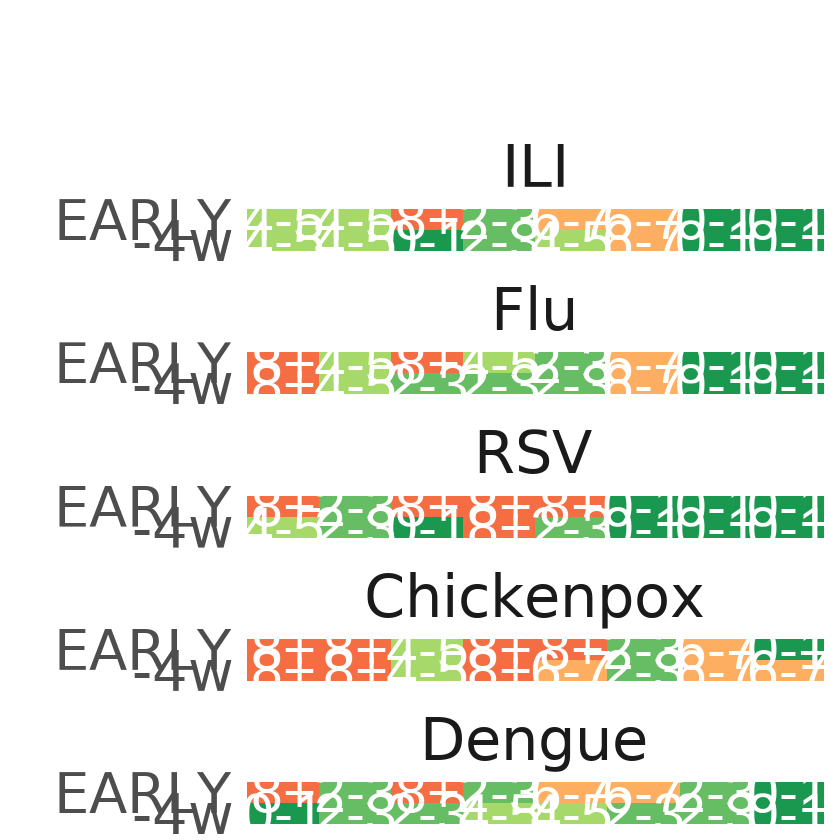

In [ ]:
heatmap_data_2017 <- all_pic_data %>%
  filter(Year == 2017) %>%
  group_by(Models, Diseases, Forecast_horizons) %>%  # Include training_time for facet x-axis
  ungroup()


heatmap_data_2017$distance_category <- cut(
  as.numeric(heatmap_data_2017$distance_to_peak_abs / 7),
  breaks = c(-Inf,1, 3, 5, 7, Inf),
  labels = c("0-1", "2-3", "4-5", "6-7", "8+"),
  right = TRUE
)


# Define color palette
color_palette <- c(
  "#1a9850",  # Dark Green (Lowest)
  "#66bd63",  # Light Green
  "#a6d96a",  # Yellow-Green
  "#fdae61",  # Orange
  "#f46d43",  # Red-Orange
  "#d73027"   # Dark Red (Highest)
)

ggplot(heatmap_data_2017, aes(x = Models,
                              y = factor(Forecast_horizons, levels = rev(unique(Forecast_horizons))),
                              fill = distance_category)) +
  geom_tile() +
  geom_text(aes(label = distance_category), color = "white", size = 15) +

  # Use 2 columns for facet arrangement
  facet_wrap(~ Diseases, ncol = 1, scales = "free_x") +

  # Change legend title
  scale_fill_manual(values = color_palette, name = "Absolute Distance to the Peak (week)") +
  labs(x = "Models", y = NULL) +  # Remove y-axis title
  ggtitle("") +
  theme_minimal() +
  theme(
    text = element_text(family = "DejaVu Sans"),
    axis.text.x = element_blank(),  # Remove x-axis text
    #axis.text.x = element_text(size = 42, angle = 90, vjust = 0.5, hjust = 1),
    axis.text.y = element_text(size = 42),
    axis.title.x = element_blank(),
    strip.text = element_text(size = 44, face = "plain"),
    panel.grid = element_blank(),
    panel.border = element_blank(),
    plot.title = element_text(size = 80),
    legend.position = "none"  # Removes the legend
  )

 ggsave("heatmap_plot_2017.png", width = 8, height = 6, dpi = 500)  # Adjust size and resolution



In [ ]:
heatmap_data_2016$distance_category <- cut(
  as.numeric(heatmap_data_2016$distance_to_peak_abs / 7),
  breaks = c(-Inf,1, 3, 5, 7, Inf),
  labels = c("0-1", "2-3", "4-5", "6-7", "8+"),
  right = TRUE
)
ggplot(heatmap_data_2016, aes(x = factor(training_time, levels = unique(training_time)),
                         y = Model, fill = distance_category)) +
  geom_tile() +  # Heatmap tiles
  geom_text(aes(label = distance_category), color = "white", size = 5) +  # Add labels
  facet_wrap(~ Data, ncol = 1, scales = "free_y") +  # Separate rows, shared x-axis, free y-axis
  scale_fill_manual(values = color_palette, name = "Distance to the peak (Weeks)") +  # Custom colors
  ggtitle("Faceted Heatmap of Median Distance to Peak Abs (2016)") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size = 14),  # Rotate x-axis labels
    axis.text.y = element_text(size = 14),  # Increase y-axis text size
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
    axis.title.x = element_text(size = 16, face = "bold"),  # X-axis title bold
    axis.title.y = element_text(size = 16, face = "bold"),  # Y-axis title bold
    strip.text = element_text(size = 18, face = "bold"),  # Facet labels bigger
    panel.grid = element_blank(),  # Remove grid lines
    panel.border = element_blank()  # Remove border
  )

ggsave("heatmap_plot_2016.png", width = 10, height = 20, dpi = 300)  # Adjust size and resolution


Warning message:
“Removed 32 rows containing missing values or values outside the scale range
(`geom_text()`).”
Warning message:
“Removed 32 rows containing missing values or values outside the scale range
(`geom_text()`).”


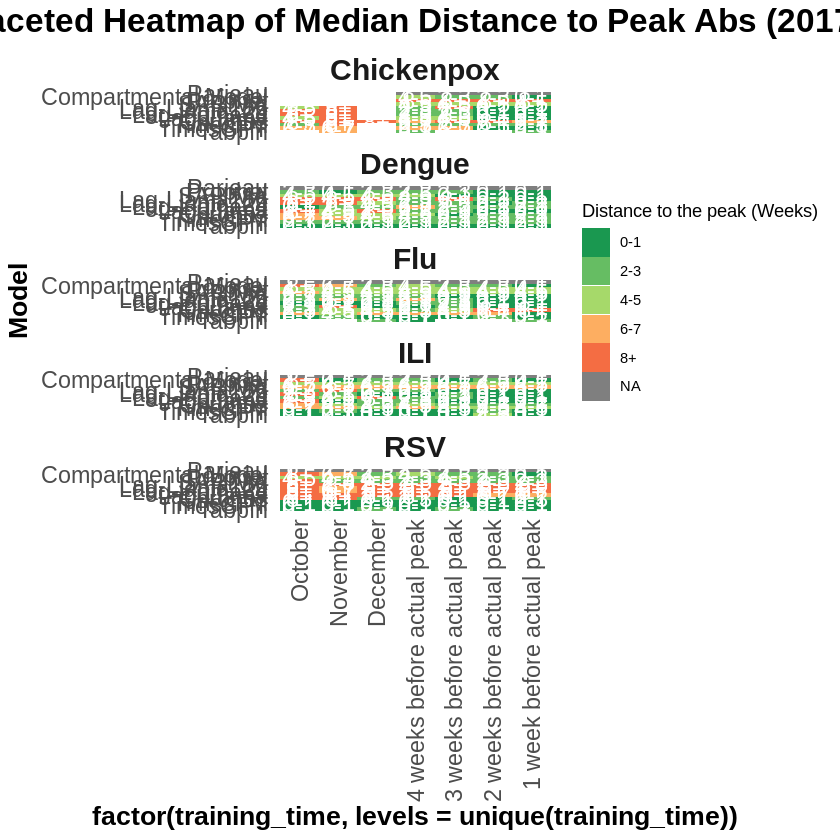

Warning message:
“Removed 32 rows containing missing values or values outside the scale range
(`geom_text()`).”
Warning message:
“Removed 32 rows containing missing values or values outside the scale range
(`geom_text()`).”


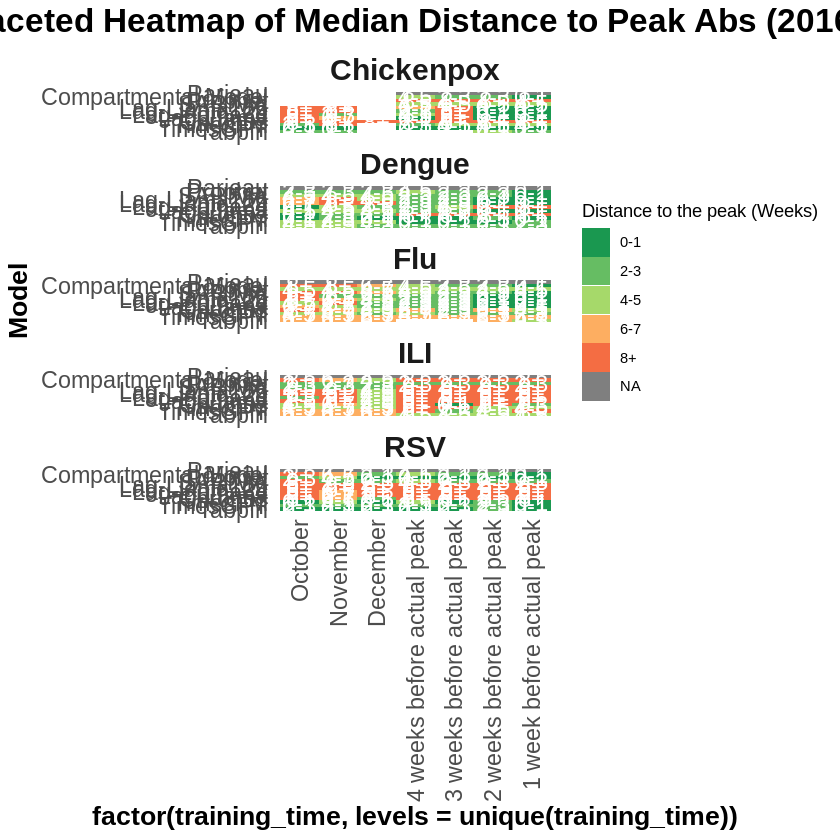

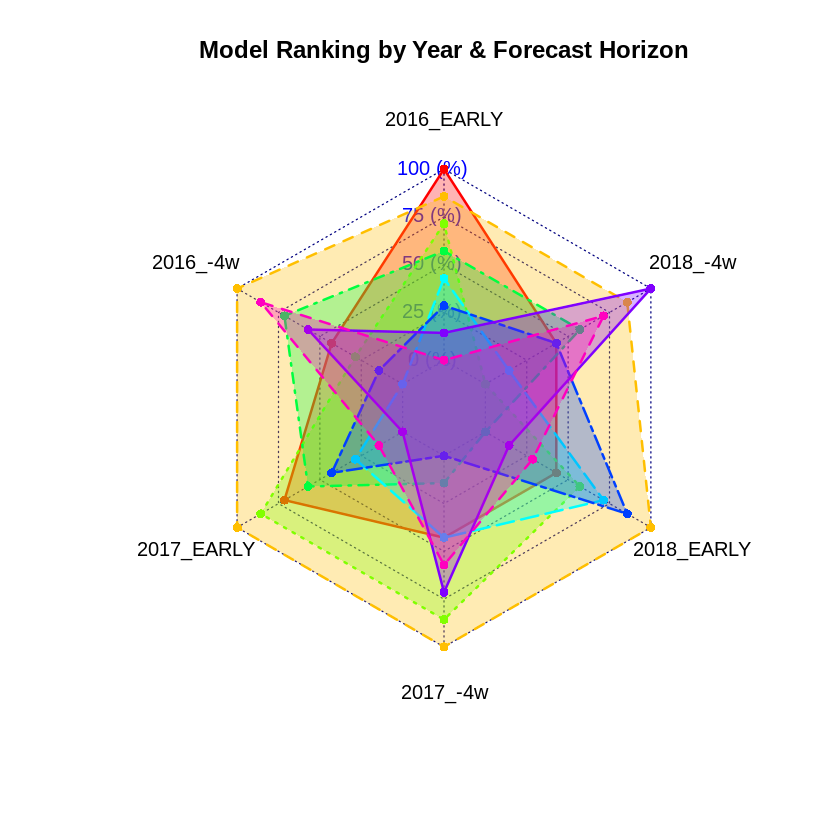

In [ ]:
# Load necessary libraries
library(dplyr)
library(tidyr)
library(fmsb)
library(ggplot2)

# Compute ranking for each model per Year & Forecast Horizon
ranked_data <- all_pic_data %>%
  filter(Year %in% c(2016, 2017, 2018)) %>%
  group_by(Year, Forecast_horizons, Models) %>%
  summarise(avg_distance_to_peak = mean(as.numeric(distance_to_peak_abs), na.rm = TRUE), .groups = "drop") %>%
  arrange(Year, Forecast_horizons, avg_distance_to_peak) %>%
  group_by(Year, Forecast_horizons) %>%
  mutate(Rank = rank(avg_distance_to_peak, ties.method = "min")) %>%
  ungroup()

# Create a new column "Year_Forecast" for radar chart axis labels
ranked_data <- ranked_data %>%
  mutate(Year_Forecast = paste(Year, Forecast_horizons, sep = "_")) %>%
  select(Year_Forecast, Models, Rank)

# Reshape data to wide format (Models as rows, Year+Forecast as columns)
radar_data <- ranked_data %>%
  pivot_wider(names_from = Year_Forecast, values_from = Rank, values_fn = mean)  # Ensures unique values

# Ensure all columns except the first are numeric (for radar chart)
radar_data[-1] <- lapply(radar_data[-1], function(x) as.numeric(as.character(x)))

# Normalize ranking: Convert rank so that best model (Rank=1) is highest in the radar chart
max_rank <- max(radar_data[-1], na.rm = TRUE)
radar_data[-1] <- max_rank + 1 - radar_data[-1]

# Add min-max rows required for fmsb radar chart
radar_data <- rbind(
  max_rank, rep(1, ncol(radar_data) - 1), radar_data[-1]
)

# Convert to data frame
radar_data <- as.data.frame(radar_data)

# Set row names properly
rownames(radar_data)[1:2] <- c("Max", "Min")

# ✅ Generate Radar Chart for Model Rankings
par(mfrow = c(1, 1))  # Single radar chart for all models

radarchart(radar_data,
           axistype = 1,
           title = "Model Ranking by Year & Forecast Horizon",
           pcol = rainbow(nrow(radar_data) - 2),  # Different colors for each model
           plwd = 2,  # Line width
           pfcol = alpha(rainbow(nrow(radar_data) - 2), 0.3)  # Transparent fill
)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in plot.window(...):
“"legend" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"legend" is not a graphical parameter”
Warning message in title(...):
“"legend" is not a graphical parameter”
Warning message in plot.window(...):
“"legend" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"legend" is not a graphical parameter”
Warning message in title(...):
“"legend" is not a graphical parameter”
Warning message in plot.window(...):
“"legend" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"legend" is not a graphical parameter”
Warning message in title(...):
“"legend" is not a graphical parameter”
Warning message in plot.window(...):
“"legend" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"legend" is not a graphical parameter”
Warning message in title(...):
“"legend" is not a graphical para

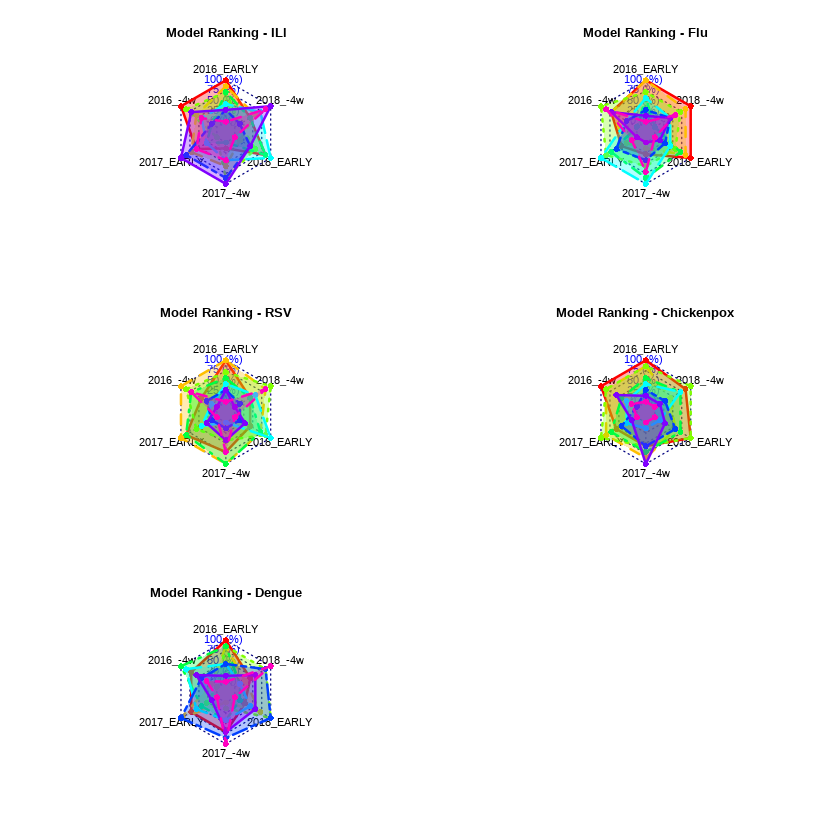

In [ ]:
# Load necessary libraries
install.packages("fmsb")
library(dplyr)
library(tidyr)
library(fmsb)
library(ggplot2)

# Compute ranking for each model per Year, Forecast Horizon, and Disease
ranked_data <- all_pic_data %>%
  filter(Year %in% c(2016, 2017, 2018)) %>%
  group_by(Year, Forecast_horizons, Diseases, Models) %>%
  summarise(avg_distance_to_peak = mean(as.numeric(distance_to_peak_abs), na.rm = TRUE), .groups = "drop") %>%
  arrange(Year, Forecast_horizons, Diseases, avg_distance_to_peak) %>%
  group_by(Year, Forecast_horizons, Diseases) %>%
  mutate(Rank = rank(avg_distance_to_peak, ties.method = "min")) %>%
  ungroup()

# Create a new column "Year_Forecast" for radar chart axis labels
ranked_data <- ranked_data %>%
  mutate(Year_Forecast = paste(Year, Forecast_horizons, sep = "_")) %>%
  select(Diseases, Year_Forecast, Models, Rank)

# Get unique diseases
unique_diseases <- unique(ranked_data$Diseases)

# Set up plotting area
par(mfrow = c(ceiling(length(unique_diseases) / 2), 2))  # Arrange multiple plots

# Loop through each disease and create a radar chart
for (disease in unique_diseases) {
  # Filter data for the current disease
  disease_data <- ranked_data %>% filter(Diseases == disease) %>%
    select(-Diseases) %>%  # Remove disease column
    pivot_wider(names_from = Year_Forecast, values_from = Rank, values_fn = mean)  # Convert to wide format

  # Ensure all columns except the first are numeric
  disease_data[-1] <- lapply(disease_data[-1], function(x) as.numeric(as.character(x)))

  # Normalize ranking: Convert rank so that best model (Rank=1) is highest in the radar chart
  max_rank <- max(disease_data[-1], na.rm = TRUE)
  disease_data[-1] <- max_rank + 1 - disease_data[-1]

  # Add min-max rows required for fmsb radar chart
  disease_data <- rbind(
    max_rank, rep(1, ncol(disease_data) - 1), disease_data[-1]
  )

  # Convert to data frame
  disease_data <- as.data.frame(disease_data)

  # Set row names properly
  rownames(disease_data)[1:2] <- c("Max", "Min")

  # ✅ Generate Radar Chart for each Disease
  radarchart(disease_data,
             axistype = 1,
             title = paste("Model Ranking -", disease),
             pcol = rainbow(nrow(disease_data) - 2),  # Different colors for each model
             plwd = 2,  # Line width
             pfcol = alpha(rainbow(nrow(disease_data) - 2), 0.3),  # Transparent fill
             legend = list(legend = disease_data$Models, col = rainbow(nrow(disease_data) - 2), lwd = 2, bty = "n")  # Keep legend
  )
}
